<a href="https://colab.research.google.com/github/medulka/LLMs/blob/main/Time_series_analysis_RNN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intro**

A methodical summary for investigating the time series analyses using ML

# **Preparation**
\
**Common imports**

In [ ]:
!python --version


Python 3.10.12


In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.17.0'

In [ ]:
import sklearn
print(sklearn.__version__)

1.5.2


In [ ]:
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

**To stabilise the seed**



In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

**Visualisation Functions**

In [ ]:
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# directory to save the pictures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "RNN"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGE_PATH,exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path=os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bx', markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'ro')
    plt.grid(True)

    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

**Generate the dataset**

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size,1)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 * 10)) # wave 1
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 * 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
n_steps = 50

**Define the series**

In [ ]:
series = generate_time_series(10000, n_steps = n_steps +1)

**Define the training dataset**

In [ ]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
# X_train[1]
# y_train[1]
X_train.shape, y_train.shape


((7000, 50, 1), (7000, 1))

**Define the validation dataset**

In [ ]:
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(2000, 50, 1) (2000, 1)
(1000, 50, 1) (1000, 1)


**Plot the series**

Saving figure time_series_plot


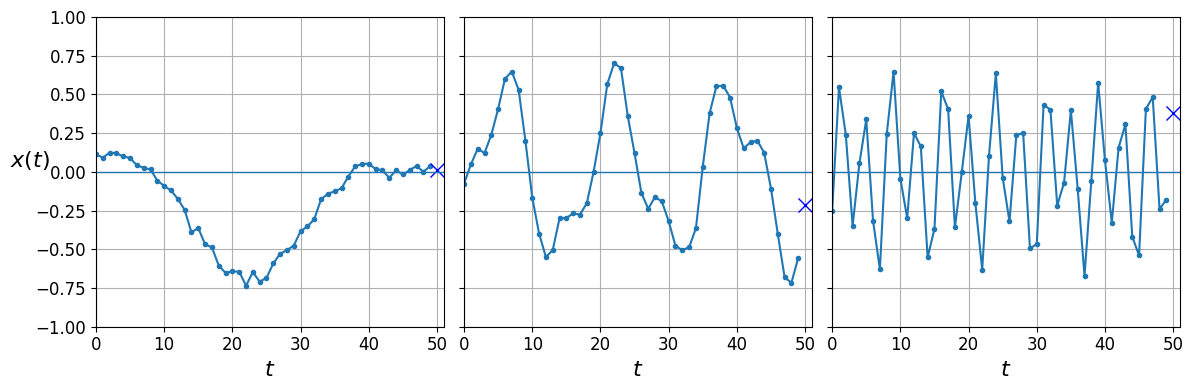

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (12,4))

for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col == 0 else None))

save_fig('time_series_plot')
plt.show()


# **Basic RNNs**

**Computing some baselines**

**1) Naive prediction** \
supposes that the next value ist the mean of the last three values

In [ ]:
y_pred = X_valid[:, -1]
y_pred.shape


(2000, 1)

In [ ]:
# did not work out
# np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

In [ ]:
def loss(predicted_y, desired_y):
    return tf.reduce_sum(tf.square(predicted_y - desired_y))

In [ ]:
loss(y_pred, y_valid)

<tf.Tensor: shape=(), dtype=float32, numpy=329.4185>

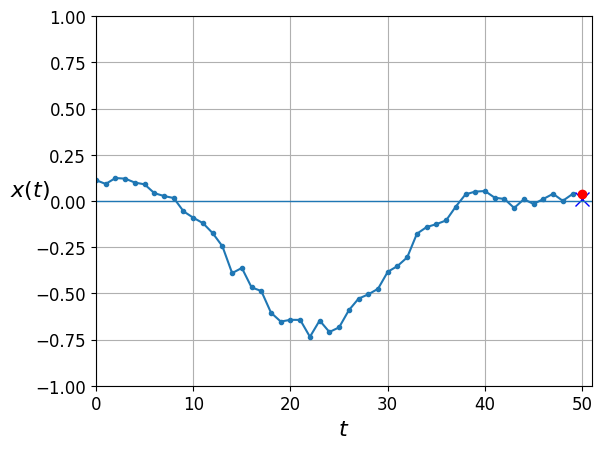

In [ ]:
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])

**2) Linear Prediction**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50,1]),
    keras.layers.Dense(1)
])
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2484 - val_loss: 0.1415
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1278 - val_loss: 0.1045
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1003 - val_loss: 0.0955
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0923 - val_loss: 0.0918
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0887 - val_loss: 0.0896
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0866 - val_loss: 0.0882
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0852 - val_loss: 0.0873
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0843 - val_loss: 0.0866
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0837 - val_loss: 0.0861
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0833 - val_loss: 0.0858
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0830 - val_loss: 0.0856
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [ ]:
print(history.history['val_loss'])

[0.14148060977458954, 0.10448367893695831, 0.0955158919095993, 0.09180334955453873, 0.08963144570589066, 0.08821351081132889, 0.08725288510322571, 0.08659525960683823, 0.08614570647478104, 0.08584041148424149, 0.0856349840760231, 0.08549834787845612, 0.08540879189968109, 0.08535129576921463, 0.08531544357538223, 0.08529412746429443, 0.08528241515159607, 0.0852769985795021, 0.08527559041976929, 0.08527668565511703]


In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0877


0.08527668565511703

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5,
             loss, 'b.-', label='Training Loss')
    plt.plot(np.arange(len(val_loss)) + 1,
             val_loss, 'r.-', label='Validation Loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

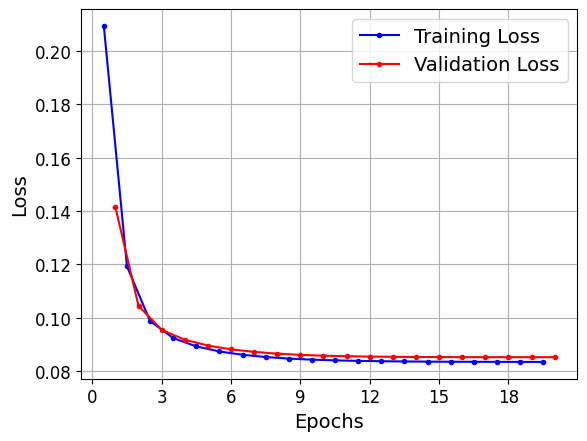

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


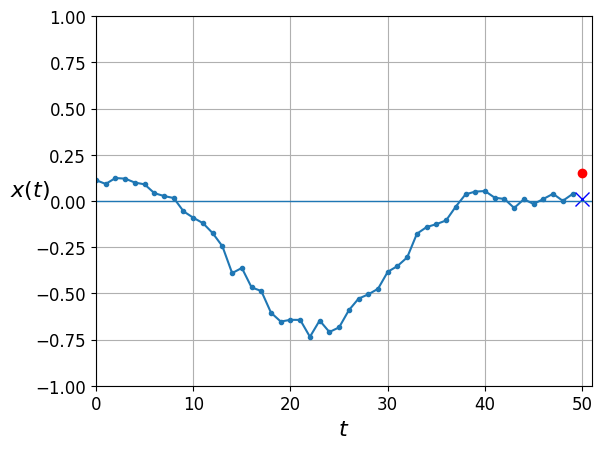

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])
plt.show()

**3) Using a simple RNN**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape = [None, 1]) ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss = 'mse', optimizer = optimiser, metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0000e+00 - loss: 0.1509 - val_accuracy: 0.0000e+00 - val_loss: 0.1403
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - loss: 0.1403 - val_accuracy: 0.0000e+00 - val_loss: 0.1358
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0000e+00 - loss: 0.1351 - val_accuracy: 0.0000e+00 - val_loss: 0.1253
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0000e+00 - loss: 0.1219 - val_accuracy: 0.0000e+00 - val_loss: 0.1010
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0989 - val_accuracy: 0.0000e+00 - val_loss: 0.0932
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0944 - val_accuracy: 0.0000e+00 - val_loss: 0.0930
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0943 - val_accuracy: 0.0000e+00 - val_loss: 0.0930
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0945


[0.0931638702750206, 0.0]

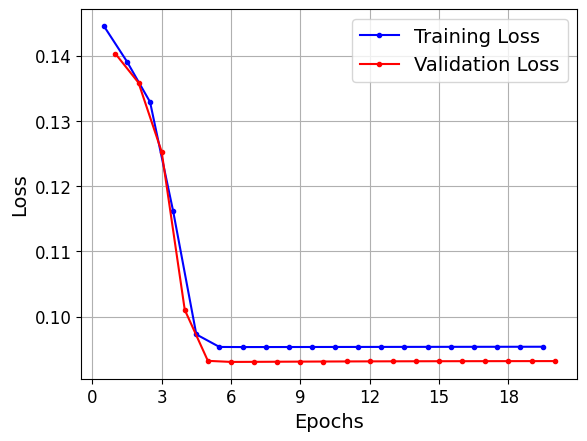

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


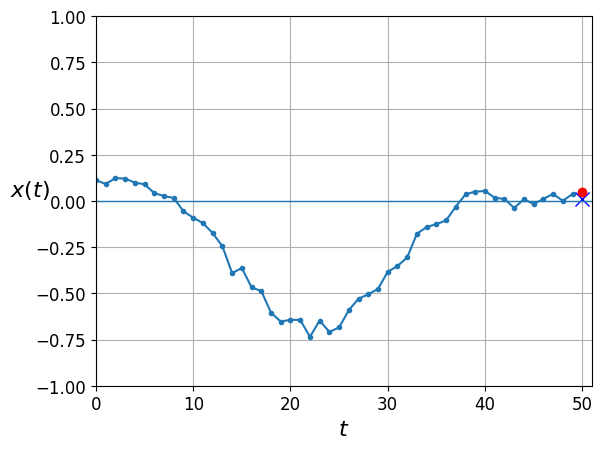

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])

**4) Using Deep RNN**

**4A) Start with a simple RNN**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.1662 - val_loss: 0.0608
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0538 - val_loss: 0.0467
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0443 - val_loss: 0.0416
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0405 - val_loss: 0.0395
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0383 - val_loss: 0.0383
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0366 - val_loss: 0.0373
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0353 - val_loss: 0.0365
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0342 - val_loss: 0.0358
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0332 - val_loss: 0.0351
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0323 - val_loss: 0.0345
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0316 - val_loss: 0.0338
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0303


0.029013147577643394

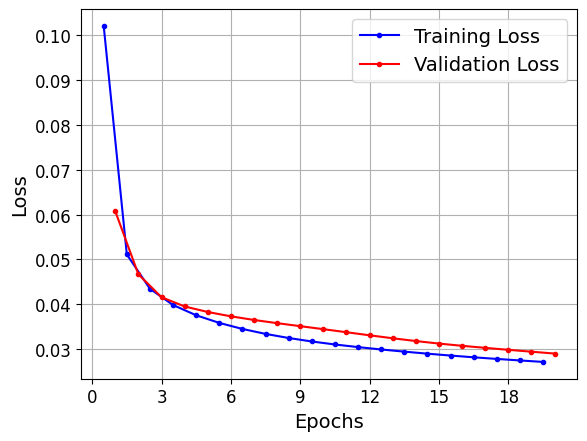

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


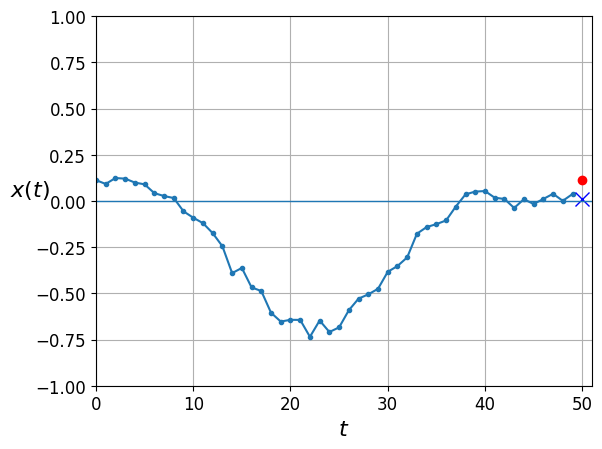

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])

**4B) Modify it to a CNN**

Replacing the last layer to a dense layer
the second layer outputs only the last value

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1937 - val_loss: 0.0629
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0572 - val_loss: 0.0438
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0454 - val_loss: 0.0403
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0408 - val_loss: 0.0378
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0378 - val_loss: 0.0352
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0354 - val_loss: 0.0336
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0336 - val_loss: 0.0324
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0321 - val_loss: 0.0314
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0309 - val_loss: 0.0304
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0298 - val_loss: 0.0295
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0288 - val_loss: 0.0287
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0239


0.02336709387600422

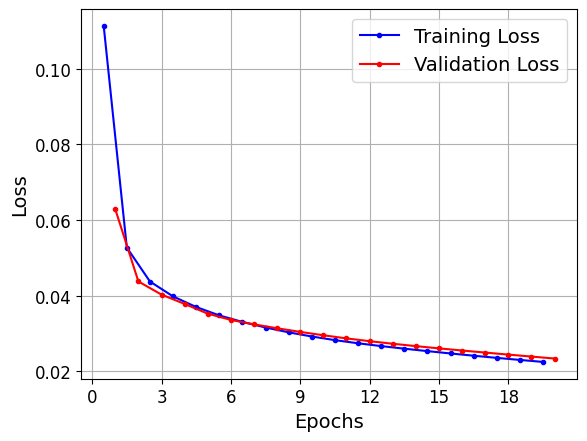

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


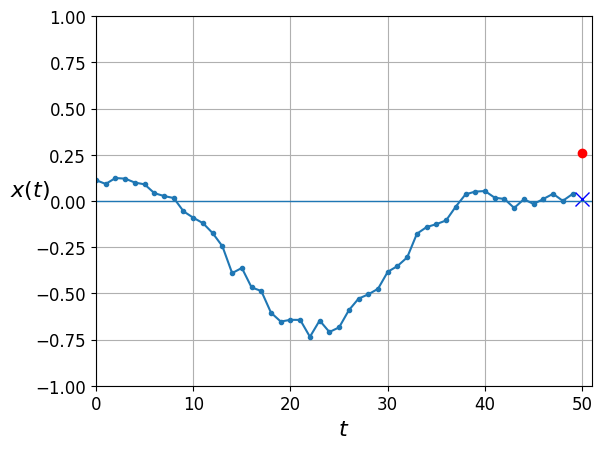

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0,0], y_pred[0,0])
plt.show()